In [5]:
import torchvision.transforms as transforms
from torchvision import transforms
from torchvision.io import read_image
import torch
from PIL import Image
import torchvision.models as models
import numpy as np

from modeci_mdf.interfaces.pytorch import pytorch_to_mdf
from modeci_mdf.execution_engine import EvaluableGraph

In [7]:
input_image = Image.open("img1.jpeg")
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')
# Instantiate the pre-trained ResNet18 model
model = models.resnet18(pretrained=True)

with torch.no_grad():
    output = model(input_batch)
# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
print(output[0])
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)
print(probabilities)

tensor([-4.6709e-01, -4.0117e-01, -6.5607e-01, -1.4973e+00, -7.6730e-01,
        -5.2448e-02, -5.2945e-01,  5.2269e-01,  3.7287e-01, -9.0071e-01,
        -1.0920e+00, -8.8285e-01, -3.8129e-01, -1.0781e+00, -1.1823e+00,
        -8.1298e-01, -9.1969e-01, -3.2910e-01, -7.1835e-01, -6.7984e-01,
        -1.6096e+00, -7.3443e-01, -1.4383e+00,  1.4147e-01, -9.4663e-01,
        -1.0857e+00, -7.7305e-01, -1.1266e+00, -8.8738e-01, -2.7526e-01,
        -9.2091e-01, -7.2337e-01, -4.6043e-01, -5.1632e-01, -3.7360e-01,
        -4.5182e-01,  6.4157e-01, -6.4771e-01, -2.4097e-01, -4.2868e-02,
        -6.8587e-01, -8.5262e-01, -1.0401e+00, -3.3032e-01, -6.1023e-01,
        -4.5101e-01, -7.9541e-01, -4.0941e-01, -1.3343e+00, -1.2023e+00,
        -5.9369e-01,  4.7314e-01, -3.4427e-01, -7.4621e-01, -3.2258e-01,
        -1.2457e+00, -4.8368e-01, -1.6292e+00, -6.4064e-01, -5.6865e-01,
         7.7134e-01,  1.0700e-01, -1.6447e-01,  1.4494e-01, -8.0058e-01,
        -2.8841e-01, -2.6397e-01, -4.3071e-01, -7.6

In [8]:
mdf_model, params_dict = pytorch_to_mdf(
        model=model,
        args=input_batch,
        trace=True,
    )

In [9]:
mdf_graph = mdf_model.graphs[0]
# mdf_graph_nodes = mdf_graph.nodes[id='Conv_499']
params_dict["input1"] = input_batch.detach().numpy()

eg = EvaluableGraph(graph=mdf_graph, verbose=False)

eg.evaluate(initializer=params_dict)

output_mdf = eg.output_enodes[0].get_output()
op_label_mdf = np.argmax(output_mdf)


Init graph: ResNetGraph
Evaluating graph: ResNetGraph, root nodes: ['Conv_123'], with array format numpy


Converting MDF graph: ResNetGraph to graphviz (level: 1, format: png)
    Node: Conv_123
    Node: BatchNormalization_124_125_126
    Node: Relu_127
    Node: MaxPool_128
    Node: Conv_129
    Node: BatchNormalization_130_131_132
    Node: Relu_133
    Node: Conv_134
    Node: BatchNormalization_135_136_137
    Node: Add_138
    Node: Relu_139
    Node: Conv_140
    Node: BatchNormalization_141_142_143
    Node: Relu_144
    Node: Conv_145
    Node: BatchNormalization_146_147_148
    Node: Add_149
    Node: Relu_150
    Node: Conv_151
    Node: BatchNormalization_152_153_154
    Node: Relu_155
    Node: Conv_156
    Node: BatchNormalization_157_158_159
    Node: Conv_160
    Node: BatchNormalization_161_162_163
    Node: Add_164
    Node: Relu_165
    Node: Conv_166
    Node: BatchNormalization_167_168_169
    Node: Relu_170
    Node: Conv_171
    Node: BatchNormalization_172_173_174
    Node: Add_175
    Node: Relu_176
    Node: Conv_177
    Node: BatchNormalization_178_179_180
    N

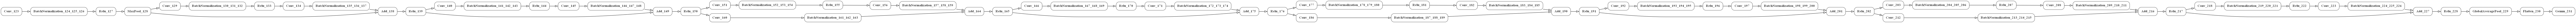

In [10]:
mdf_model.to_graph_image(
    engine="dot",
    output_format="png",
    view_on_render=False,
    level=1,
    filename_root="example",
    only_warn_on_fail=True,
    is_horizontal = True
)
from IPython.display import Image
Image(filename="example.png")

In [11]:
try:
    from IPython.display import Image
    onnx_graph = Image(filename="example.onnx.png")
    display(onnx_graph)
    
except:
    import netron
    torch.onnx.export(
            model,
            input_batch,
            "example.onnx",
            verbose=True,
            input_names=[],
            opset_version=9,
        )
    netron.start("example.onnx")


graph(%input.1 : Float(1, 3, 224, 224, strides=[150528, 50176, 224, 1], requires_grad=0, device=cpu),
      %fc.weight : Float(1000, 512, strides=[512, 1], requires_grad=1, device=cpu),
      %fc.bias : Float(1000, strides=[1], requires_grad=1, device=cpu),
      %193 : Float(64, 3, 7, 7, strides=[147, 49, 7, 1], requires_grad=0, device=cpu),
      %194 : Float(64, strides=[1], requires_grad=0, device=cpu),
      %196 : Float(64, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=0, device=cpu),
      %197 : Float(64, strides=[1], requires_grad=0, device=cpu),
      %199 : Float(64, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=0, device=cpu),
      %200 : Float(64, strides=[1], requires_grad=0, device=cpu),
      %202 : Float(64, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=0, device=cpu),
      %203 : Float(64, strides=[1], requires_grad=0, device=cpu),
      %205 : Float(64, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=0, device=cpu),
      %206 : Float(64, strides=[1], require

Serving 'example.onnx' at http://localhost:8080
